In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
} 

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

In [5]:
query = '''
WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS start_mn
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
sessions AS
  (SELECT start_mn,
          DATE_TRUNC('month', event_time)::date AS event_mn,
          COUNT(DISTINCT p.user_id) AS users_cnt
   FROM profile p
   JOIN tools_shop.events e ON p.user_id = e.user_id
   GROUP BY 1,
            2)
SELECT start_mn,
       event_mn,
       users_cnt,
       LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn) AS previous_day_users_cnt,
       ROUND((1 - (users_cnt::numeric / LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn))) * 100, 2) AS churn_rate
FROM sessions
WHERE start_mn BETWEEN '2018-01-01' AND '2018-06-01'
  AND event_mn BETWEEN '2018-01-01' AND '2018-12-01';
'''

In [6]:
churn_rate_df = pd.read_sql_query(query, con = engine)

In [7]:
print(churn_rate_df.head())

     start_mn    event_mn  users_cnt  previous_day_users_cnt  churn_rate
0  2018-01-01  2018-01-01        257                     NaN         NaN
1  2018-01-01  2018-02-01         67                   257.0       73.93
2  2018-01-01  2018-03-01         41                    67.0       38.81
3  2018-01-01  2018-04-01         44                    41.0       -7.32
4  2018-01-01  2018-05-01         42                    44.0        4.55


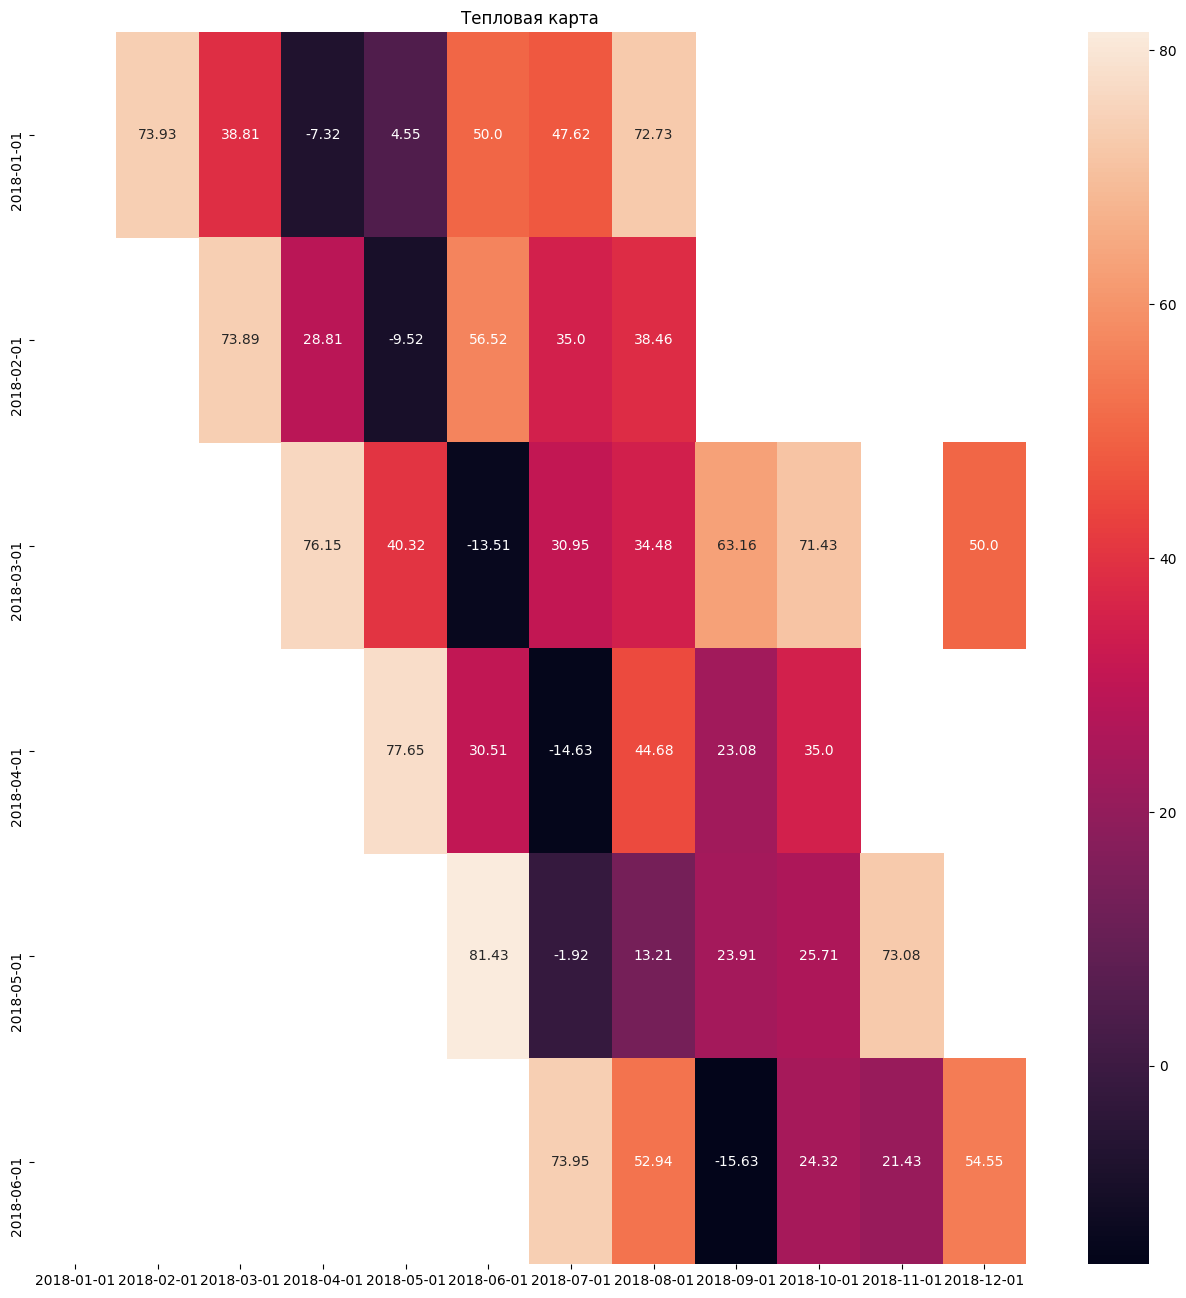

In [9]:
# создаём сводную таблицу с результатами
churn = churn_rate_df.pivot('start_mn', 'event_mn', 'churn_rate')
churn.index = [str(x)[0:10] for x in churn.index]
churn.columns = [str(x)[0:10] for x in churn.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(churn, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()